# Simple 2D Sparse GP
We will test to ensure that our sparse GP implementation works correctly in this notebook.

## Generate Syntethic Data
We generate a simple dataset for testing with inputs in the range [0, 200]. We'll use a sinusoidal function with some noise added.

In [1]:
import jax
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
from jax.scipy.linalg import cho_factor, cho_solve
import imageio
import os

from kernels import *
from sparse_gp import *

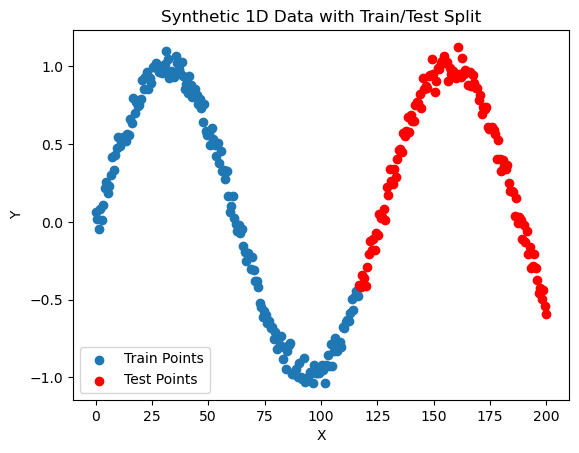

In [2]:
# Inputs
X = onp.linspace(0, 200, 300).reshape(-1, 1)

# Outputs: Sine function with noise
Y = onp.sin(X * 0.05) + 0.05 * onp.random.normal(size=X.shape)

# Training and testing split
X_train, Y_train = X[:175], Y[:175]
X_test, Y_test = X[175:], Y[175:]

# Plot data
plt.scatter(X_train, Y_train, label="Train Points")
plt.scatter(X_test, Y_test, label="Test Points", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Synthetic 1D Data with Train/Test Split")
plt.show()

## Plotting Code
### Predictive Mean and Uncertainty Plot

In [3]:
def plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, model_fn):
    # Ensure input arrays are two-dimensional
    X_test = X_test.reshape(-1, 1)
    X_train = X_train.reshape(-1, 1)
    Z = Z.reshape(-1, 1)
    numInducing = Z.shape[0]

    # Make predictions on the test set using the optimized hyperparameters
    posterior_mean, posterior_var = model_fn(X_test, X_train, Y_train, Z, optimized_hyperparams)

    # Convert JAX arrays to NumPy arrays for plotting and ensure all are 1D
    posterior_mean = onp.array(posterior_mean).flatten()
    posterior_var = onp.array(posterior_var).flatten()
    X_test = onp.array(X_test).flatten()

    # Ensure all variances are positive
    posterior_var = onp.maximum(posterior_var, 1e-10)

    # Plot the points, predictive mean, and confidence interval
    plt.figure(figsize=(10, 6))
    plt.scatter(X_train, Y_train, color='blue', label="Training Points")
    plt.scatter(X_test, Y_test, color='red', label="Test Points")

    # Plot predictive mean line and 95% confidence interval
    plt.plot(X_test, posterior_mean, 'green', label="Predicted Mean")
    plt.fill_between(X_test,
                     (posterior_mean - 1.96 * onp.sqrt(posterior_var)),
                     (posterior_mean + 1.96 * onp.sqrt(posterior_var)),
                     color='green', alpha=0.2, label="95% Confidence Interval")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
    plt.title(f"Sparse GP Prediction with Uncertainty (Including {numInducing} Inducing Points)")
    plt.show()
#

### Negative Log Predictive Density Plot

In [4]:
def calculate_nlpd(X, Y, Z, hyperparams, model_fn, noise_variance):
    posterior_mean, posterior_var = model_fn(X, X_train, Y_train, Z, hyperparams)
    nlpd = neg_log_predictive_density(Y, posterior_mean, posterior_var, noise_variance)
    return nlpd
#

### ELBO Plot

In [5]:
def plot_elbo(history):
    # Extract ELBO values and steps from history
    elbo_values = [entry["elbo"] for entry in history]
    steps = [entry["step"] for entry in history]
    
    # Plot the ELBO values over steps
    plt.figure(figsize=(10, 5))
    plt.plot(steps, elbo_values, label="ELBO", color='blue')
    plt.xlabel("Step")
    plt.ylabel("ELBO")
    plt.title("ELBO Over Training Steps")
    plt.legend()
    plt.show()
#

### Kernel Hyperparameter Plot

In [6]:
def plot_kernel_hyperparameters(history):
    # Extract training steps
    steps = [entry["step"] for entry in history]
    
    # Function to normalize values between 0 and 1
    def normalize(values):
        min_val, max_val = min(values), max(values)
        return [(v - min_val) / (max_val - min_val) for v in values] if max_val > min_val else values

    # Extract and normalize raw hyperparameters
    weights_1 = normalize([entry["hyperparams"][0] for entry in history])
    weights_2 = normalize([entry["hyperparams"][1] for entry in history])
    # noise_variance_sqexp = normalize([entry["hyperparams"][2] for entry in history])
    signal_variance_sqexp = normalize([entry["hyperparams"][3] for entry in history])
    length_scale_sqexp = normalize([entry["hyperparams"][4] for entry in history])
    # noise_variance_linear = normalize([entry["hyperparams"][5] for entry in history])
    signal_variance_linear = normalize([entry["hyperparams"][6] for entry in history])
    
    # Plot normalized kernel hyperparameters
    plt.figure(figsize=(12, 8))

    # Plot for Squared-Exponential Kernel (Blue)
    plt.plot(steps, weights_1, label="Weight (Squared-Exponential Kernel)", color='blue', linestyle='--')
    # plt.plot(steps, noise_variance_sqexp, label="Noise Variance (Sq-Exp)", color='blue', linestyle='-.')
    plt.plot(steps, signal_variance_sqexp, label="Signal Variance (Sq-Exp)", color='blue', linestyle='-')
    plt.plot(steps, length_scale_sqexp, label="Length Scale (Sq-Exp)", color='blue', linestyle=':')

    # Plot for Linear Kernel (Red)
    plt.plot(steps, weights_2, label="Weight (Linear Kernel)", color='red', linestyle='--')
    # plt.plot(steps, noise_variance_linear, label="Noise Variance (Linear)", color='red', linestyle='-.')
    plt.plot(steps, signal_variance_linear, label="Signal Variance (Linear)", color='red', linestyle='-')

    # Plot configuration
    plt.xlabel("Step")
    plt.ylabel("Normalized Parameter Value (0 to 1)")
    plt.title("Normalized Kernel Hyperparameter Values Over Training Steps")
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    plt.show()
#

# Test Experiment 1
Test on 20 inducing points.

## Parameter Initialization

In [7]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=20)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams():
    # Assuming two kernels, with unconstrained weights and initial values for each kernel's hyperparams
    initial_weights = [onp.log(0.5), onp.log(0.5)]  # log-space for unconstrained initial weights
    hyperparams_sqexp = [0.1, 1.0, 10.0]  # Initial values for noise, signal, length_scale for sq-exp kernel
    hyperparams_linear = [0.1, 1.0]  # Initial values for noise, signal for linear kernel
    
    # Concatenate all hyperparameters
    initial_params = initial_weights + hyperparams_sqexp + hyperparams_linear
    return np.array(initial_params)

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams()

## Define the Optimization Loop for ELBO

In [8]:
# Set the gradient ascent step size and number of steps
step_size = 5e-4
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -160.32330119647116
Step 10, ELBO: -158.55909370644514
Step 20, ELBO: -156.4788888385409
Step 30, ELBO: -153.89211588000268
Step 40, ELBO: -150.41580034854258
Step 50, ELBO: -145.28363591351615
Step 60, ELBO: -137.1793528540137
Step 70, ELBO: -124.99711218118802
Step 80, ELBO: -109.88275981095556
Step 90, ELBO: -94.14960757842343
Step 100, ELBO: -78.71454224228233
Step 110, ELBO: -63.704902383086164
Step 120, ELBO: -49.269040611877074
Step 130, ELBO: -35.699176068974126
Step 140, ELBO: -23.38009496487294
Step 150, ELBO: -12.720036933318255
Step 160, ELBO: -4.055226857523792
Step 170, ELBO: 2.4704041607502347
Step 180, ELBO: 6.982854762406447
Step 190, ELBO: 9.843121682815507
Step 200, ELBO: 11.51657412592806
Step 210, ELBO: 12.434139168453129
Step 220, ELBO: 12.916243263832087
Step 230, ELBO: 13.165902799809515
Step 240, ELBO: 13.297599378422461
Step 250, ELBO: 13.370851462649512
Step 260, ELBO: 13.415032973760589
Step 270, ELBO: 13.444255555834985
Step 280, ELBO: 13.4652

In [9]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of First 2 Weights:", np.sum(optimized_hyperparams[:2]))

Optimized Hyperparameters: [9.94878888e-01 5.12111228e-03 1.10517092e+00 4.69858482e+00
 4.21947112e+03 1.10517092e+00 2.55669101e+00]
sum of First 2 Weights: 1.0


## Predict and Plot the Results

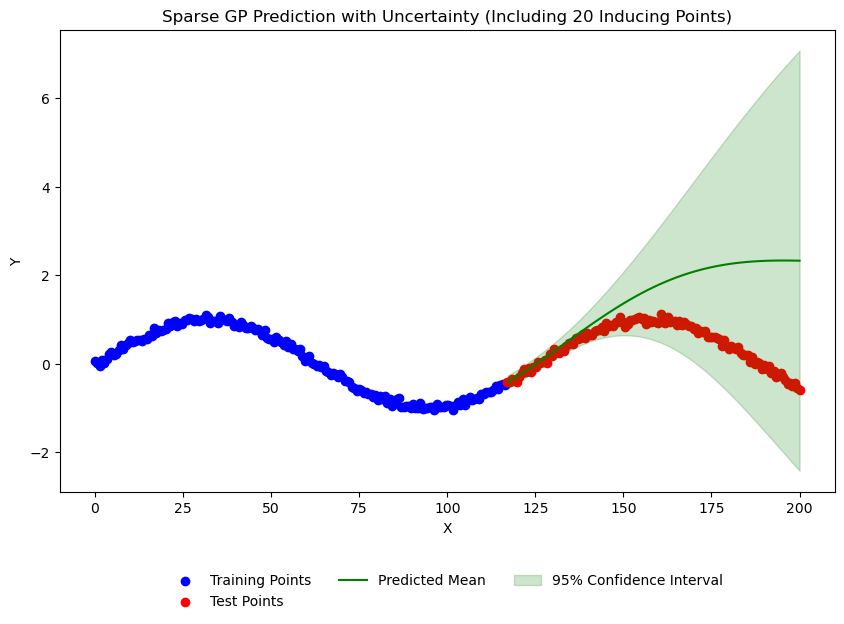

In [10]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [11]:
# Extract weights from optimized hyperparameters (assuming the first two entries are the weights)
weights = optimized_hyperparams[:2]

# Convert weights to percentages
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[2]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[6]:.4f}")

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 99.49%
Kernel 2 (Linear): 0.51%

Other Hyperparameters:
Kernel 1 - Noise Variance: 1.1052
Kernel 1 - Signal Variance: 4.6986
Kernel 1 - Length Scale: 4219.4711
Kernel 2 - Noise Variance: 1.1052
Kernel 2 - Signal Variance: 2.5567


## NLPD on Test Data

In [12]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 0.9724
Test NLPD: 1.8198


## ELBO Maximization

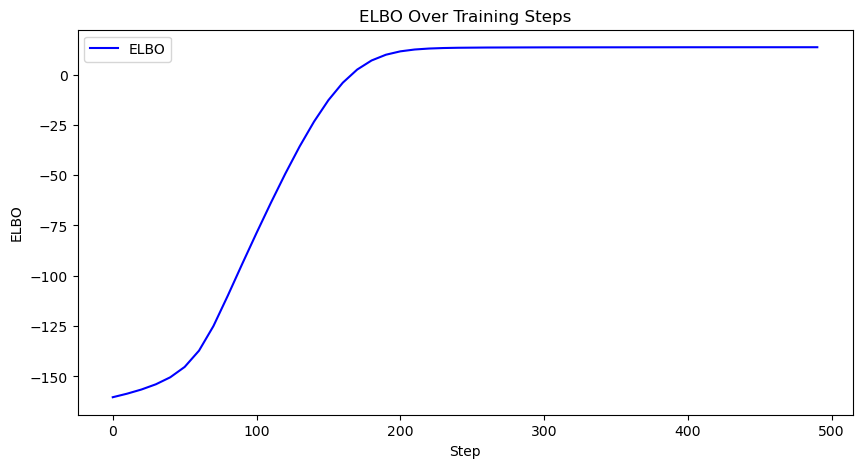

In [13]:
plot_elbo(history)

## Kernel Hyperparameters

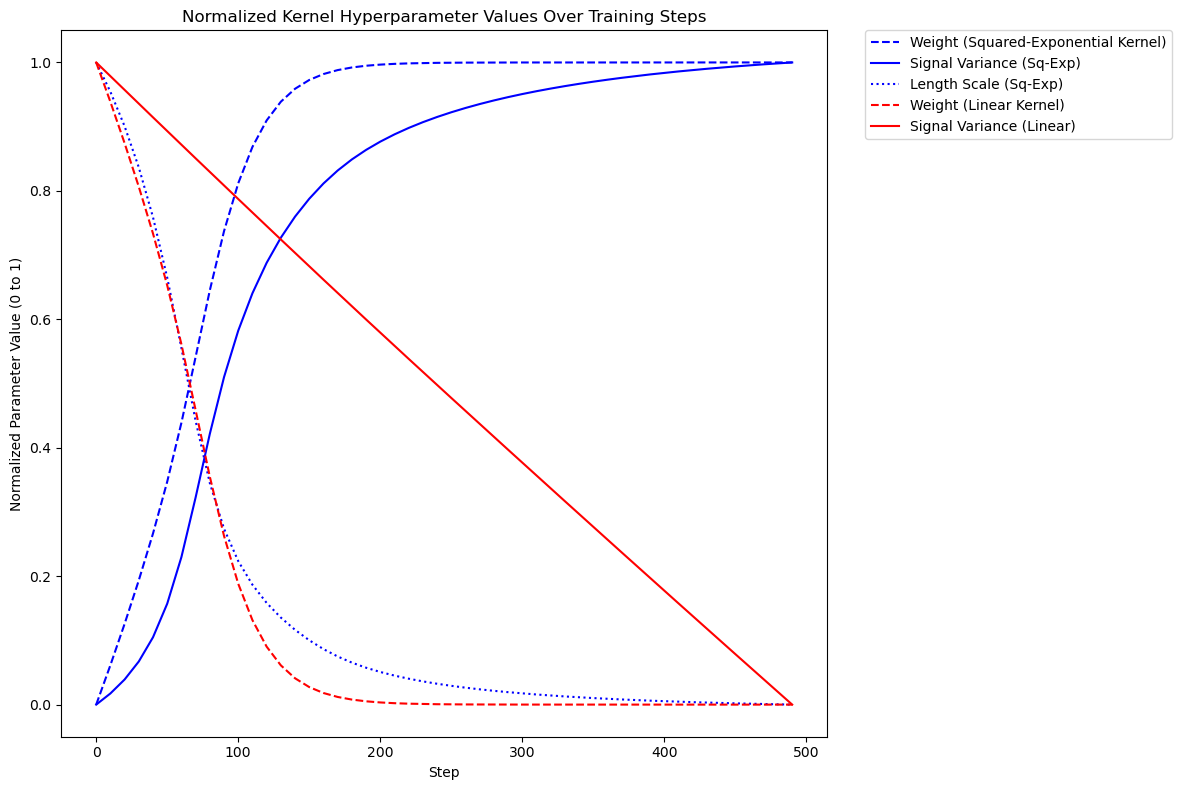

In [14]:
plot_kernel_hyperparameters(history)

# Test Experiment 2
Test on 100 inducing points.

## Parameter Initialization

In [23]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=100)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams():
    # Assuming two kernels, with unconstrained weights and initial values for each kernel's hyperparams
    initial_weights = [onp.log(0.5), onp.log(0.5)]  # log-space for unconstrained initial weights
    hyperparams_sqexp = [0.1, 1.0, 10.0]  # Initial values for noise, signal, length_scale for sq-exp kernel
    hyperparams_linear = [0.1, 1.0]  # Initial values for noise, signal for linear kernel
    
    # Concatenate all hyperparameters
    initial_params = initial_weights + hyperparams_sqexp + hyperparams_linear
    return np.array(initial_params)

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams()

## Define the Optimization Loop for ELBO

In [24]:
# Set the gradient ascent step size and number of steps
step_size = 5e-4
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -160.32293242498054
Step 10, ELBO: -158.55866339676663
Step 20, ELBO: -156.47839436082984
Step 30, ELBO: -153.89156322836638
Step 40, ELBO: -150.41521486418713
Step 50, ELBO: -145.2830827166749
Step 60, ELBO: -137.17894608038932
Step 70, ELBO: -124.99690408613083
Step 80, ELBO: -109.88260932439252
Step 90, ELBO: -94.14939688564175
Step 100, ELBO: -78.71427206408208
Step 110, ELBO: -63.70461080493058
Step 120, ELBO: -49.26877188075146
Step 130, ELBO: -35.69899072887233
Step 140, ELBO: -23.38008800469504
Step 150, ELBO: -12.720320790109696
Step 160, ELBO: -4.0558590585948195
Step 170, ELBO: 2.469474887559784
Step 180, ELBO: 6.981751066894617
Step 190, ELBO: 9.84195618948931
Step 200, ELBO: 11.515404123003037
Step 210, ELBO: 12.43297281055328
Step 220, ELBO: 12.915066226353787
Step 230, ELBO: 13.164698493113946
Step 240, ELBO: 13.296356828872035
Step 250, ELBO: 13.369565738711657
Step 260, ELBO: 13.413703250601714
Step 270, ELBO: 13.442883242987278
Step 280, ELBO: 13.4638630

In [25]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of First 2 Weights:", np.sum(optimized_hyperparams[:2]))

Optimized Hyperparameters: [9.94878792e-01 5.12120802e-03 1.10517092e+00 4.69830661e+00
 4.22093596e+03 1.10517092e+00 2.55668721e+00]
sum of First 2 Weights: 1.0


## Predict and Plot the Results

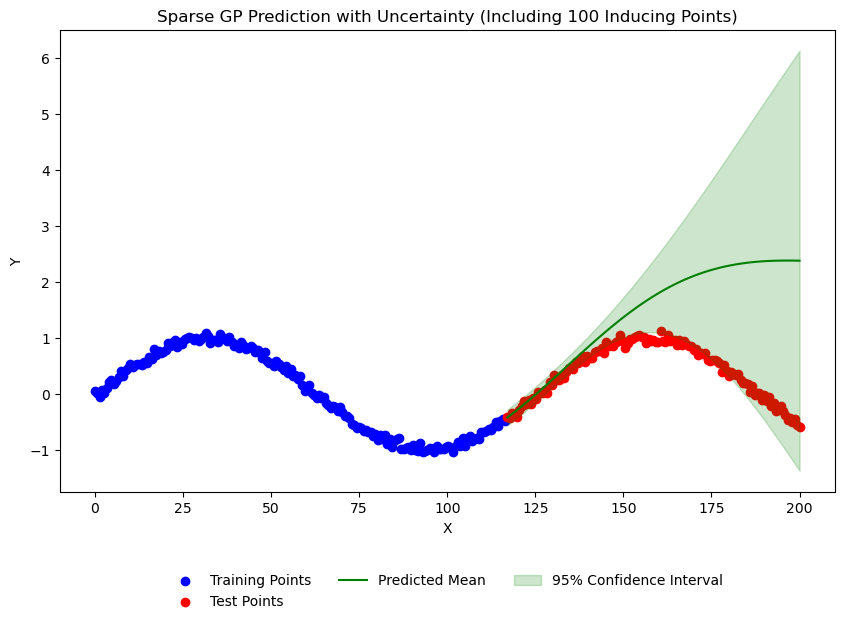

In [26]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [27]:
# Extract weights from optimized hyperparameters (assuming the first two entries are the weights)
weights = optimized_hyperparams[:2]

# Convert weights to percentages
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[2]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[6]:.4f}")

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 99.49%
Kernel 2 (Linear): 0.51%

Other Hyperparameters:
Kernel 1 - Noise Variance: 1.1052
Kernel 1 - Signal Variance: 4.6983
Kernel 1 - Length Scale: 4220.9360
Kernel 2 - Noise Variance: 1.1052
Kernel 2 - Signal Variance: 2.5567


## NLPD

In [28]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 0.9724
Test NLPD: 1.8292


## ELBO Maximization


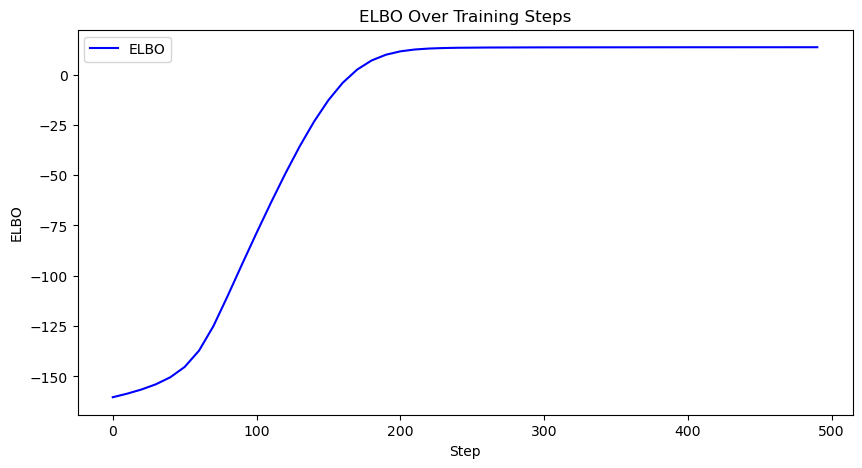

In [29]:
plot_elbo(history)

## Kernel Hyperparameters

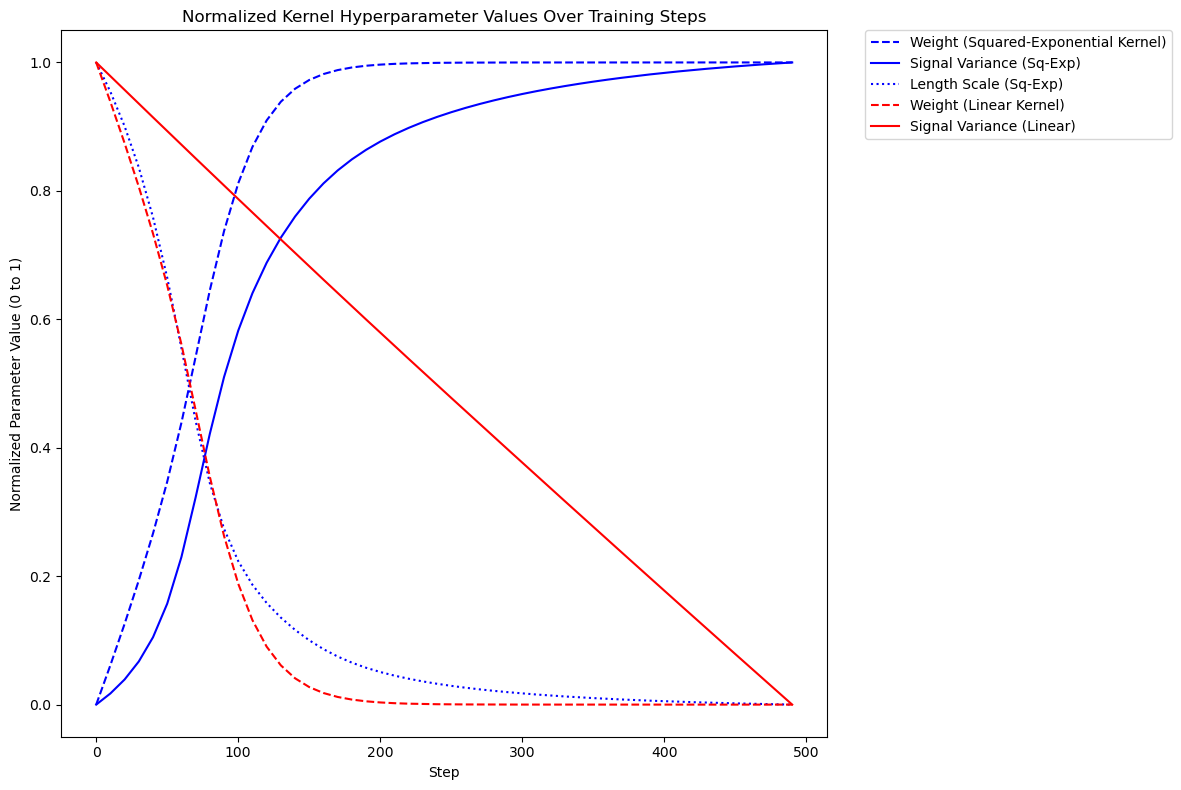

In [30]:
plot_kernel_hyperparameters(history)